In [90]:
import os 
import time
import re
import pandas as pd 
import spacy
from datetime import date

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
#from selenium.webdriver.common.keys import Keys

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])


In [112]:
def start_selenium(source, url):
    options = Options()
    options.headless = True
    driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)

    if source == 'FOX':
        driver.get(url)
        WebDriverWait(driver, .5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))).click()
        for i in range(300):
            try:
                driver.execute_script("arguments[0].scrollIntoView();", WebDriverWait(driver, .5).until(EC.visibility_of_element_located((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))))
                WebDriverWait(driver, .5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".load-more > a:nth-child(1)"))).click()
            except:
                pass

    if source == 'NPR':
        driver.get("https://www.npr.org/sections/news/archive")
        scroll_number = 10 #max scrolls -- it will do one less than this 

    return driver.page_source

In [116]:
def show_entity_labels():
    print("""
    PERSON:        People's names
    NORP:          Nationalities or religiouse or political groups.
    FAC:           Infrastructure such as buildings, airports, highways, bridges, etc.
    ORG:           Companies, agencies, institutions, etc.
    GPE:           Countries, cities, states.
    LOC:           Non-GPE locations, mountain ranges, bodies of water. 
    PRODUCT:       Objects, vehicles, foods, etc. (Not services.)
    EVENT:         Names of events. Natural disasters, battles, sports events, etc. Coronavirus strains like "omicron" are categorized as events.
    WORK_OF_ART:   Titles of books, songs, etc.
    LAW:           Names of documents made into laws.
    LANGUAGE:      Named languages.
    DATE:          Absolute or relative dates or periods.
    TIME:          Times smaller than a day.
    PERCENT:       Percentage, including "%".
    MONEY:         Monetary values.
    QUANTITY:      Measurements, as of weight or distance.
    ORDINAL:       Terms denoting order, such as "first" or "second."
    CARDINAL:      Numerals that do not fall under another time. 
    """)

def clean_entities(ls):
    ls = [word.lower() for word in ls]
    ls = [re.sub(r'^the ', '', word) for word in ls]
    return ls

def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict


def time_stamp():
    today = date.today()
    d_today = today.strftime("%m-%d-%Y")

    return d_today

def barplot_entities(df, filter, source):
    df = df[df['entity_label'] == filter]
    df = df['entity_text'].tolist()
    df = clean_entities(df)
    df = count_words(df)
    df = pd.DataFrame(
    {'word': df.keys(), 'count': df.values() } )
    
    df = df[:25].copy()
    df.sort_values(by = ['count'], inplace = True, ascending = True)

    plt.barh(df['word'], df['count'])
    plt.ylabel(filter + ' Name')
    plt.title('Top ' + filter + 's Mentioned in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [16,9]

    plt.savefig('/home/stephbuon/projects/entascope/' + source + '_' + filter + '.pdf')
    plt.show()
    plt.close()


In [120]:
def scrape_pages(url, source, ts):

    # selenium is used to scroll enter    
    ps = start_selenium(source, url)

    #response = requests.get(url)
    start_page = BeautifulSoup(ps, 'html.parser')
    
    scraped_pages = {}
    #article_id = 0
    out = {}

    for link in start_page.findAll('a'):
        try:
            page_url = link['href']

            if keyword.search(page_url):
                if not page_url in scraped_pages.keys():
                    #article_id = article_id + 1
                    # keep track of pages that have been scraped
                    scraped_pages[page_url] = source

                    next_page = requests.get(page_url)

                    if source == 'FOX':
                        if not 'https' in next_page:
                            next_page = 'https://www.foxnews.com/' + next_page

                    page_content = BeautifulSoup(next_page.text, 'html.parser')

                    #paragraph_id = 0
                    for paragraph in page_content.findAll('p'):
                        paragraph = list(paragraph.stripped_strings)
                    
                        # each sentence is a list
                        for sentence in paragraph: 
                            sentence = nlp(sentence)

                            for entity in sentence.ents:
                                if not entity.label_ in out.keys():
                                    out[entity.label_] = [entity.text]
                                else:
                                    out[entity.label_].append(entity.text)

                    #next_page.nextfind_element_by_id('bt_gerar_cpf').click()

                            
                        # if I want to make a DF instead:
                        #paragraph_id = paragraph_id + 1
                        #out[str(article_id) + '~' + str(paragraph_id) + '~' + str(page_url) ] = list(paragraph.stripped_strings)
                
                    time.sleep(1)
   
        except:
            pass

    cycle = 0
    if not os.path.exists('/home/stephbuon/projects/entascope/scraped_pages/' + ts):
        os.mkdir('/home/stephbuon/projects/entascope/scraped_pages/' + ts)

    citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

    citations.to_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')

    named_entites = pd.DataFrame(
        {'entity_label': out.keys(), 'entity_text':out.values() } )
    named_entites = named_entites.explode('entity_text')

    for index, row in named_entites.iterrows():
        row['entity_label'] = 'EVENT' if (re.match(keyword, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'ORG' if (re.match(vaccines, row['entity_text'])) else row['entity_label']

    named_entites.to_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')

In [121]:
keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta|vaccinate|vaxx', re.IGNORECASE)
vaccines = re.compile(r'pfizer|moderna', re.IGNORECASE)

In [ ]:

#driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver')

# implicit wait for 5 seconds
#driver.implicitly_wait(5)
#driver.quit()

In [95]:
urls = ['https://www.npr.org/sections/news/', 'https://www.msnbc.com/', 'https://www.foxnews.com/']
sources = ['NPR', 'MSNBC', 'FOX']
ts = time_stamp()

#for url in urls:
#    for source in sources:
        #scrape_pages(url, source, ts)

scrape_pages('https://www.npr.org/sections/news/', 'NPR', ts)
scrape_pages('https://www.msnbc.com/', 'MSNBC', ts)
scrape_pages('https://www.foxnews.com/', 'FOX', ts)

/tmp/ipykernel_16290/1323976047.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


KeyboardInterrupt: 

In [122]:
ts = time_stamp()
# its not under us, its under politics 
scrape_pages('https://www.foxnews.com/politics', 'FOX', ts)

/tmp/ipykernel_16290/738060134.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='/home/stephbuon/projects/entascope/geckodriver', options=options)


In [104]:

fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_FOX_' + ts +'.csv')
#msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_MSNBC_' + ts +'.csv')
#npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_NPR_' + ts +'.csv')

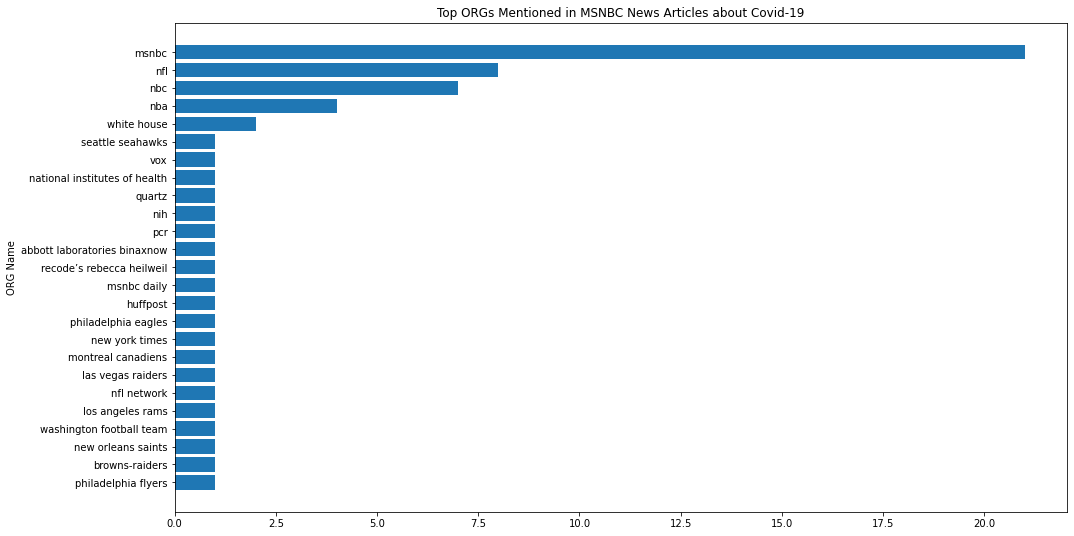

In [23]:
barplot_entities(msnbc_ne, 'ORG', 'MSNBC') # cut off the 's 

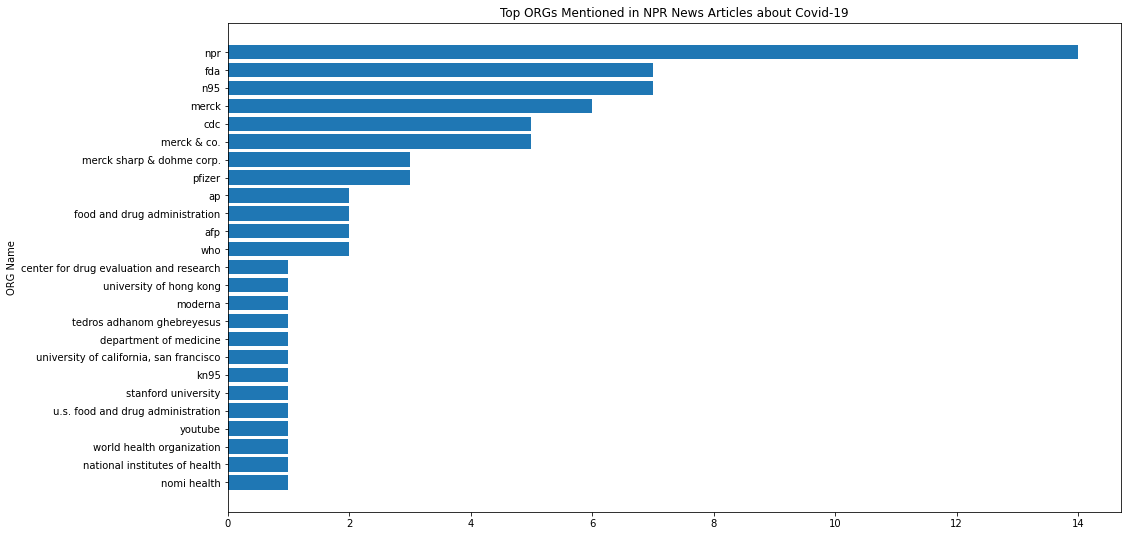

In [24]:
barplot_entities(npr_ne, 'ORG', 'NPR') # cut off the 's 

In [97]:
show_entity_labels()


    PERSON:        People's names
    NORP:          Nationalities or religiouse or political groups.
    FAC:           Infrastructure such as buildings, airports, highways, bridges, etc.
    ORG:           Companies, agencies, institutions, etc.
    GPE:           Countries, cities, states.
    LOC:           Non-GPE locations, mountain ranges, bodies of water. 
    PRODUCT:       Objects, vehicles, foods, etc. (Not services.)
    EVENT:         Names of events. Natural disasters, battles, sports events, etc. Coronavirus strains like "omicron" are categorized as events.
    WORK_OF_ART:   Titles of books, songs, etc.
    LAW:           Names of documents made into laws.
    LANGUAGE:      Named languages.
    DATE:          Absolute or relative dates or periods.
    TIME:          Times smaller than a day.
    PERCENT:       Percentage, including "%".
    MONEY:         Monetary values.
    QUANTITY:      Measurements, as of weight or distance.
    ORDINAL:       Terms denoting orde

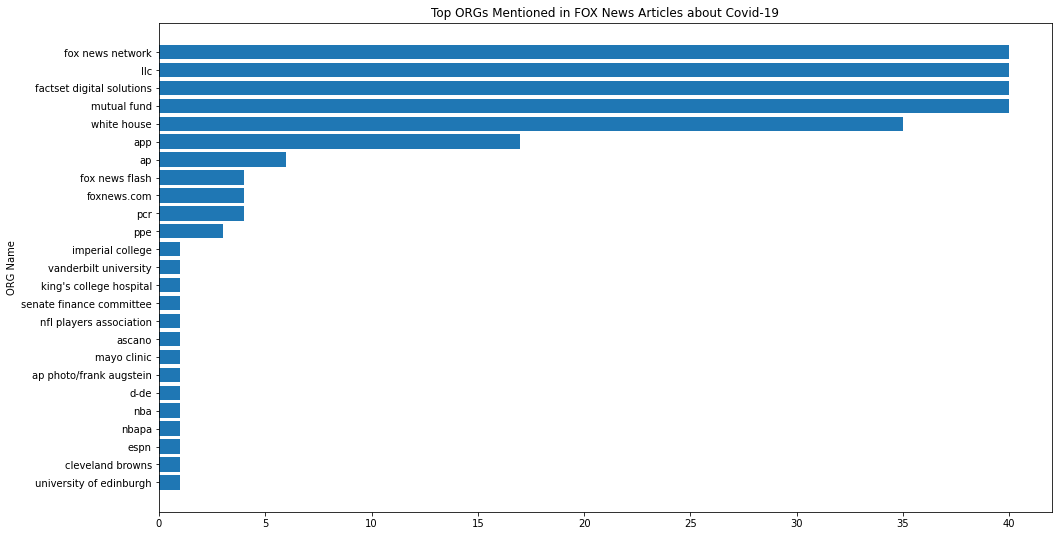

In [118]:
entities = ['EVENT', 'LAW', 'ORG']

#for entity in entities:
barplot_entities(fox_ne, 'ORG', 'FOX')